In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [246]:
from google.colab import drive

drive.flush_and_unmount()

drive.mount('/content/drive')

Mounted at /content/drive


In [247]:
# Path to your file
file_path = '/content/drive/MyDrive/Dataset/Mall_Customers.csv'

df = pd.read_csv(file_path)

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Preprocessing of the Data

In [248]:
df.shape

(200, 5)

The Mall Customers dataset contains 200 observations and 5 features.

### Visualization of the data

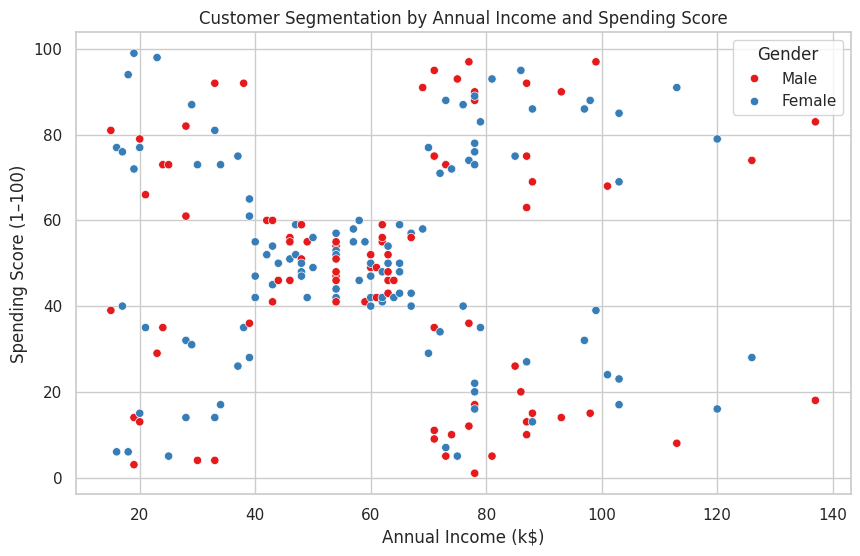

In [249]:
# Plot: Annual Income vs Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Gender',
    palette='Set1'
)
plt.title('Customer Segmentation by Annual Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1–100)')
plt.legend(title='Gender')
plt.grid(True)
plt.show()

The scatter plot illustrates the distribution of customers based on their Annual Income and Spending Score, with points color-coded by customers gender.  This visualization provides initial insights into potential groupings and the diversity in spending habits relative to income levels across genders.

In [250]:
# Drop CustomerID (not useful for clustering)
df = df.drop(['CustomerID', 'Gender'], axis=1)

In [251]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [252]:
df.isnull().sum()

,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


The dataset has no missing values

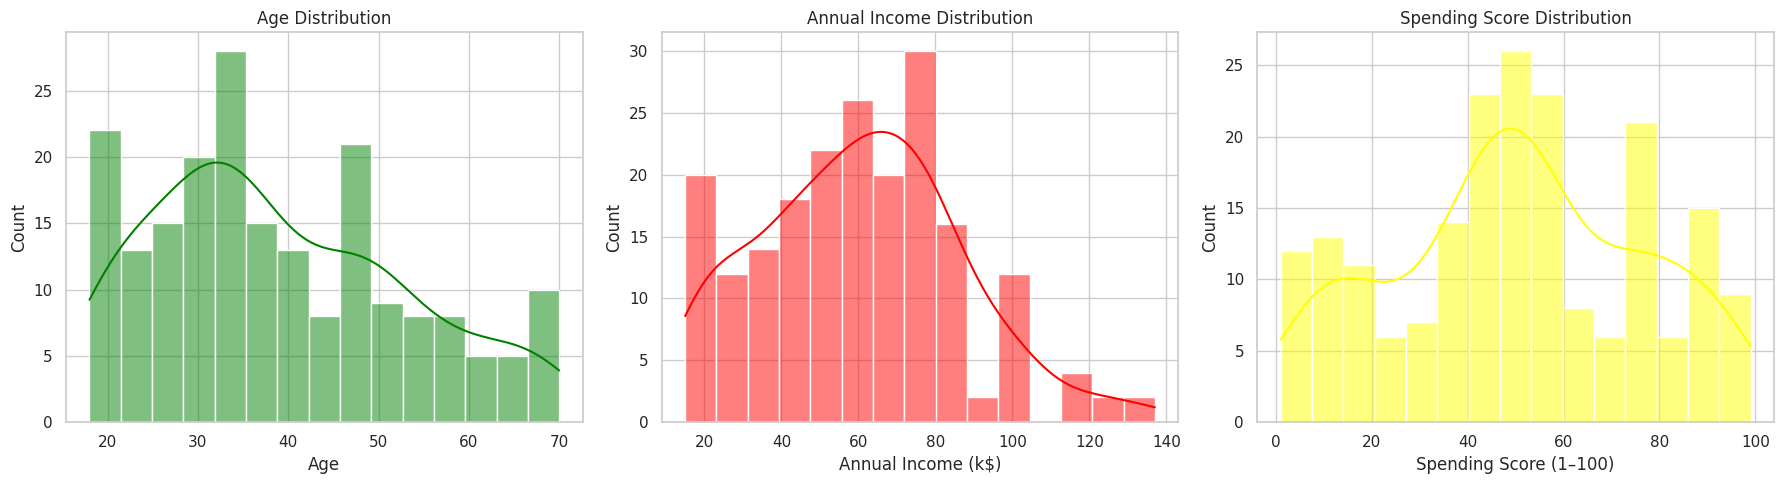

In [253]:
sns.set(style="whitegrid")


plt.figure(figsize=(18, 5))

# Histogram for Age
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], bins=15, kde=True, color='green')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Histogram for Annual Income
plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], bins=15, kde=True, color='red')
plt.title('Annual Income Distribution')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Count')

# Histogram for Spending Score
plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], bins=15, kde=True, color='yellow')
plt.title('Spending Score Distribution')
plt.xlabel('Spending Score (1–100)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The distributions of the variables age, annual income, and spending score can be seen above

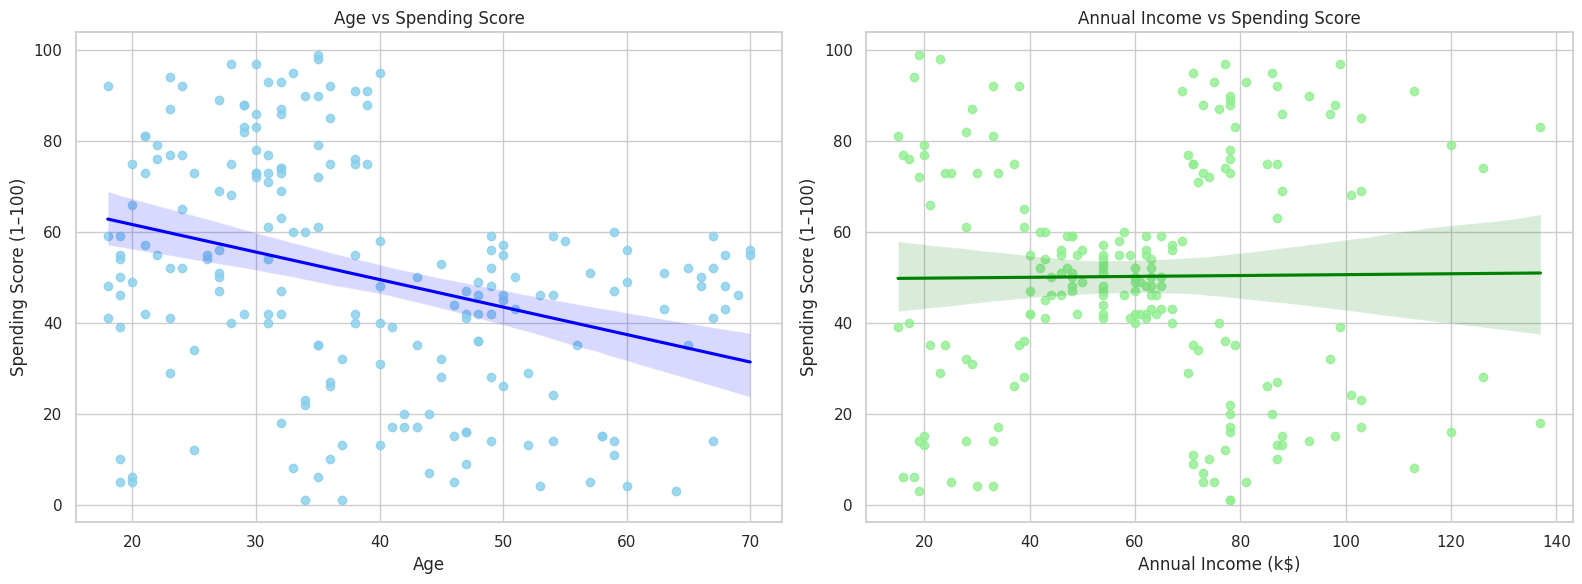

In [254]:

sns.set(style='whitegrid')

plt.figure(figsize=(16, 6))

# Age vs Spending Score
plt.subplot(1, 2, 1)
sns.regplot(
    data=df,
    x='Age',
    y='Spending Score (1-100)',
    scatter_kws={'color': 'skyblue'},
    line_kws={'color': 'blue'}
)
plt.title('Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1–100)')

# Annual Income vs Spending Score
plt.subplot(1, 2, 2)
sns.regplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    scatter_kws={'color': 'lightgreen'},
    line_kws={'color': 'green'}
)
plt.title('Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1–100)')

plt.tight_layout()
plt.show()

The left plot shows a negative correlation between age and spending score, indicating that younger customers tend to spend more than older ones. The regression line slopes downward, and the confidence band confirms this consistent trend, suggesting age is a relevant factor influencing customer spending behavior.

In contrast, the right plot reveals no clear correlation between annual income and spending score. The regression line is nearly flat, and customers across all income levels show varied spending patterns. This implies that income alone does not reliably predict how much a customer spends

### K-Means Implementation

In [255]:
def initialize_centroids(X, k):

    """
    Randomly select k points from X as initial centroids.
    """
    np.random.seed(42)

    random_indices = np.random.choice(X.shape[0], size=k, replace=False)

    centroids = X[random_indices]

    return centroids

In [256]:
def assign_clusters(X, centroids):
    """
    Assign each data point to the nearest centroid.
    Returns a vector of cluster labels.
    """
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    labels = np.argmin(distances, axis=1)

    return labels

In [257]:
def compute_centroids(X, labels, k):
    """
    Compute new centroids as the mean of assigned points for each cluster.
    """
    n_features = X.shape[1]

    centroids = np.zeros((k, n_features))

    for i in range(k):

        points_in_cluster = X[labels == i]

        if len(points_in_cluster) > 0:

            centroids[i] = points_in_cluster.mean(axis=0)
        else:

            centroids[i] = X[np.random.randint(0, X.shape[0])]

    return centroids

In [258]:
def k_means(X, k, max_iters=100):
    """
    Run the full K-means algorithm.
    Returns final centroids and cluster assignments.
    """
    centroids = initialize_centroids(X, k)

    for iteration in range(max_iters):

        labels = assign_clusters(X, centroids)

        new_centroids = compute_centroids(X, labels, k)

        # Check for convergence
        if np.allclose(centroids, new_centroids):

            print(f"K-means converged after {iteration+1} iterations.")

            break

        centroids = new_centroids

    return centroids, labels

In [259]:
def compute_inertia(X, centroids, labels):
    """
    Compute total intra-cluster variance (inertia).
    """
    inertia = 0.0
    for i in range(len(X)):

        centroid = centroids[labels[i]]

        inertia += np.sum((X[i] - centroid) ** 2)

    return inertia

### K-Means++ Implementation

In [260]:
def initialize_centroids_plus_plus(X, k):
    """
    Initialize centroids using the K-means++ strategy.
    """
    np.random.seed(42)
    n_samples, _ = X.shape

    # Randomly choose the first centroid
    centroids = [X[np.random.randint(n_samples)]]

    for _ in range(1, k):
        # Compute distances from each point to the nearest centroid
        distances = np.array([min(np.sum((x - c) ** 2) for c in centroids) for x in X])
        # Normalize distances to get probabilities
        probabilities = distances / distances.sum()
        # Choose a new centroid with weighted probability
        next_index = np.random.choice(n_samples, p=probabilities)

        centroids.append(X[next_index])

    return np.array(centroids)

In [261]:
def k_means_plus_plus(X, k, max_iters=100):
    """
    Run the K-means algorithm using K-means++ initialization.
    """
    centroids = initialize_centroids_plus_plus(X, k)

    for iteration in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = compute_centroids(X, labels, k)

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            print(f"K-means++ converged after {iteration+1} iterations.")
            break

        centroids = new_centroids

    return centroids, labels


In [262]:
# Select features for both clustering scenarios
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
X2 = df[['Age', 'Spending Score (1-100)']].values

In [263]:
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)


k = 5
centroids_kmeans, labels_kmeans = k_means(X1_scaled, k)
centroids_kpp, labels_kpp = k_means_plus_plus(X1_scaled, k)

K-means converged after 11 iterations.
K-means++ converged after 6 iterations.


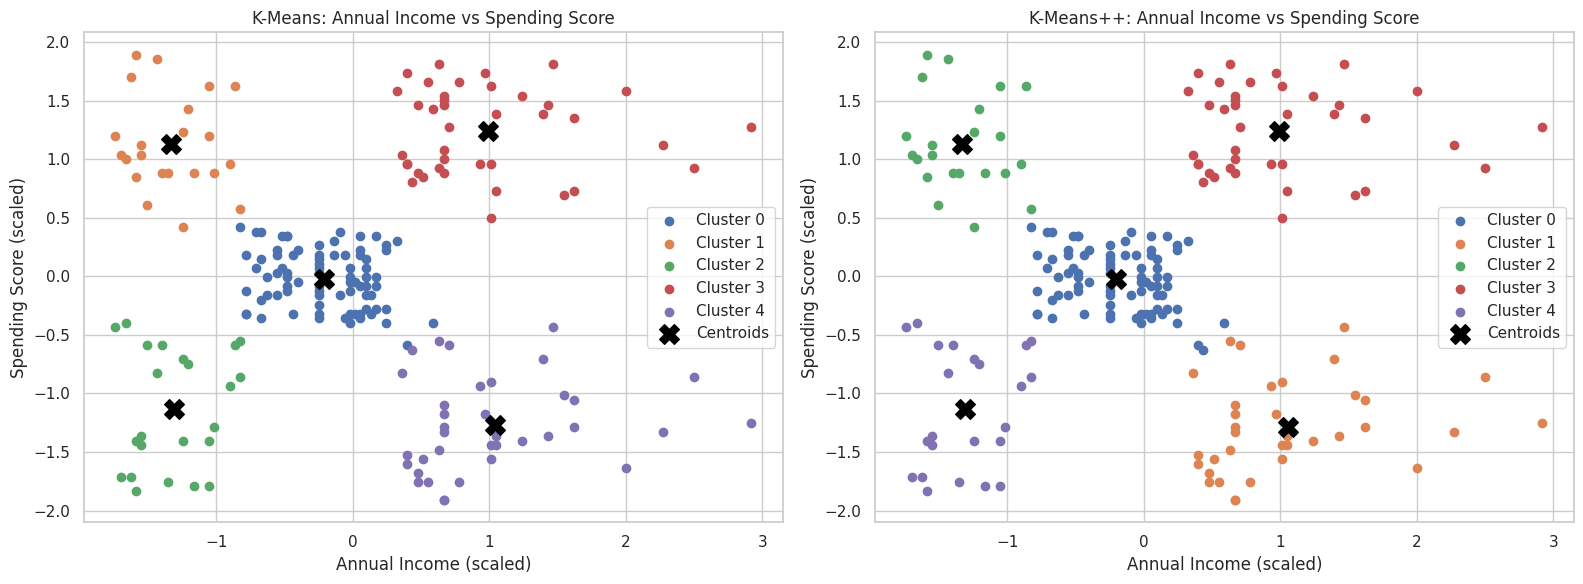

In [264]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means
for cluster_id in range(k):
    cluster_points = X1_scaled[labels_kmeans == cluster_id]
    axs[0].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
axs[0].scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], s=200, c='black', marker='X', label='Centroids')
axs[0].set_title('K-Means: Annual Income vs Spending Score')
axs[0].set_xlabel('Annual Income (scaled)')
axs[0].set_ylabel('Spending Score (scaled)')
axs[0].legend()
axs[0].grid(True)

# Plot 2: K-Means++
for cluster_id in range(k):
    cluster_points = X1_scaled[labels_kpp == cluster_id]
    axs[1].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
axs[1].scatter(centroids_kpp[:, 0], centroids_kpp[:, 1], s=200, c='black', marker='X', label='Centroids')
axs[1].set_title('K-Means++: Annual Income vs Spending Score')
axs[1].set_xlabel('Annual Income (scaled)')
axs[1].set_ylabel('Spending Score (scaled)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [265]:
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

k = 5
centroids_kmeans_age, labels_kmeans_age = k_means(X2_scaled, k)
centroids_kpp_age, labels_kpp_age = k_means_plus_plus(X2_scaled, k)

K-means converged after 7 iterations.
K-means++ converged after 9 iterations.


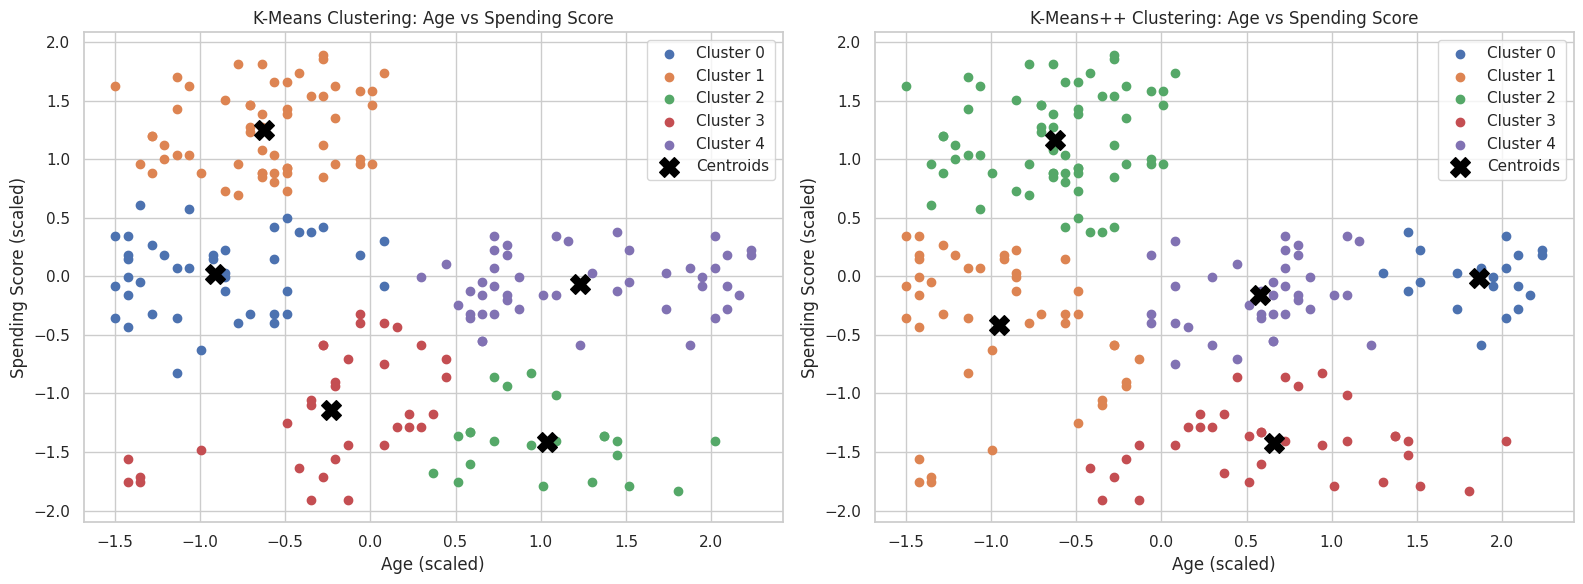

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means
for cluster_id in range(k):
    cluster_points = X2_scaled[labels_kmeans_age == cluster_id]
    ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
ax1.scatter(centroids_kmeans_age[:, 0], centroids_kmeans_age[:, 1],
            s=200, c='black', marker='X', label='Centroids')
ax1.set_title('K-Means Clustering: Age vs Spending Score')
ax1.set_xlabel('Age (scaled)')
ax1.set_ylabel('Spending Score (scaled)')
ax1.legend()
ax1.grid(True)

# Plot 2: K-Means++
for cluster_id in range(k):
    cluster_points = X2_scaled[labels_kpp_age == cluster_id]
    ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
ax2.scatter(centroids_kpp_age[:, 0], centroids_kpp_age[:, 1],
            s=200, c='black', marker='X', label='Centroids')
ax2.set_title('K-Means++ Clustering: Age vs Spending Score')
ax2.set_xlabel('Age (scaled)')
ax2.set_ylabel('Spending Score (scaled)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Using the KMeans Clustering from sklearn for comparison purposes

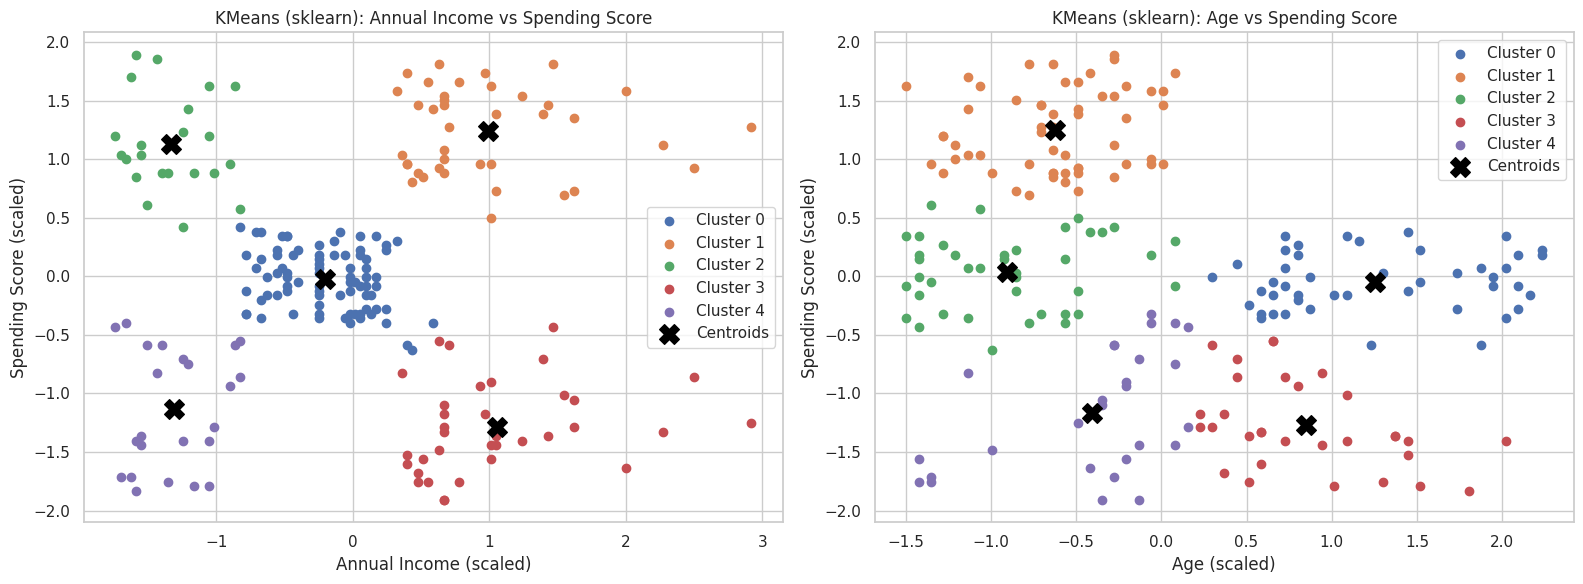

In [267]:
k = 5

# Fit sklearn KMeans on X1_scaled: Spending Score vs Annual Income
kmeans_income = KMeans(n_clusters=k, random_state=42)
labels_income = kmeans_income.fit_predict(X1_scaled)
centroids_income = kmeans_income.cluster_centers_

# Fit sklearn KMeans on X2_scaled: Spending Score vs Age
kmeans_age = KMeans(n_clusters=k, random_state=42)
labels_age = kmeans_age.fit_predict(X2_scaled)
centroids_age = kmeans_age.cluster_centers_

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Annual Income vs Spending Score
for cluster_id in range(k):
    cluster_points = X1_scaled[labels_income == cluster_id]
    axs[0].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
axs[0].scatter(centroids_income[:, 0], centroids_income[:, 1], s=200, c='black', marker='X', label='Centroids')
axs[0].set_title('KMeans (sklearn): Annual Income vs Spending Score')
axs[0].set_xlabel('Annual Income (scaled)')
axs[0].set_ylabel('Spending Score (scaled)')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Age vs Spending Score
for cluster_id in range(k):
    cluster_points = X2_scaled[labels_age == cluster_id]
    axs[1].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
axs[1].scatter(centroids_age[:, 0], centroids_age[:, 1], s=200, c='black', marker='X', label='Centroids')
axs[1].set_title('KMeans (sklearn): Age vs Spending Score')
axs[1].set_xlabel('Age (scaled)')
axs[1].set_ylabel('Spending Score (scaled)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Comparing the K-Means (random initialization) implemented from scratch vs K-Means++ using Silhouette Score

In [268]:
# Silhouette scores for Annual Income vs Spending Score
score_kmeans_income = silhouette_score(X1_scaled, labels_kmeans)
score_kpp_income = silhouette_score(X1_scaled, labels_kpp)

# Silhouette scores for Age vs Spending Score
score_kmeans_age = silhouette_score(X2_scaled, labels_kmeans_age)
score_kpp_age = silhouette_score(X2_scaled, labels_kpp_age)

print("Silhouette Score Comparison")
print("Annual Income vs Spending Score:")
print(f"  KMeans      : {score_kmeans_income:.4f}")
print(f"  KMeans++    : {score_kpp_income:.4f}")

print("\nAge vs Spending Score:")
print(f"  KMeans      : {score_kmeans_age:.4f}")
print(f"  KMeans++    : {score_kpp_age:.4f}")


Silhouette Score Comparison
Annual Income vs Spending Score:
  KMeans      : 0.5539
  KMeans++    : 0.5547

Age vs Spending Score:
  KMeans      : 0.4237
  KMeans++    : 0.4502


For the clustering based on Annual Income vs Spending Score, the silhouette score using the K-Means (random initialization) algorithm implemented from scratch is 0.5539, while the KMeans++ algorithm produces a slightly higher score of 0.5547. This indicates that both methods result in well-defined clusters, but KMeans++ has a marginal advantage, suggesting slightly better separation and tighter grouping of data points using the KMeans++ algorithm.


The clustering based on Age vs Spending Score shows lower silhouette scores, with 0.4237 for K-Means (random initialization) algorithm implemented from scratch and 0.4502 for KMeans++. These values imply that the clusters are less distinct compared to those formed using annual income and spending score. However, KMeans++ still performs better, achieving a more noticeable improvement over K-Means in this case.

### Comparing the K-Means  (random initialization) implemented from scratch vs K-Means from sklearn using Silhouette Score

In [269]:
# Silhouette scores for Annual Income vs Spending Score
score_kmeans_scratch1 = silhouette_score(X1_scaled, labels_kmeans)
score_sklearn1 = silhouette_score(X1_scaled, labels_income)


# Silhouette scores for Age vs Spending Score
score_kmeans_scratch2 = silhouette_score(X2_scaled, labels_kmeans_age)
score_sklearn2 = silhouette_score(X2_scaled, labels_age)

print("Silhouette Score Comparison")
print("Annual Income vs Spending Score:")
print(f" K-Means : {score_kmeans_scratch1:.4f}")
print(f"  sklearn KMeans : {score_sklearn1:.4f}")

print("\nAge vs Spending Score:")
print(f"  K-Means : {score_kmeans_scratch2:.4f}")
print(f"  sklearn KMeans : {score_sklearn2:.4f}")

Silhouette Score Comparison
Annual Income vs Spending Score:
 K-Means : 0.5539
  sklearn KMeans : 0.5547

Age vs Spending Score:
  K-Means : 0.4237
  sklearn KMeans : 0.4103


For the Annual Income vs Spending Score clustering, both methods achieved very similar silhouette scores: 0.5539 for the K-Means implemented from scratch and 0.5547 for scikit-learn's KMeans. This indicates that both clustering approaches produced well-separated and well-grouped clusters in this feature space. The slight difference suggests that scikit-learn's implementation might have achieved slightly better separation of clusters.

In the case of Age vs Spending Score, K-Means implemented from scratch achieved a silhouette score of 0.4237, compared to 0.4103 from scikit-learn's KMeans. While both scores are lower than those obtained from the annual income vs spending data, they still indicate reasonably good clustering performance. Interestingly, the K-Means implemented from scratch slightly outperformed the sklearn version in this case, suggesting that its centroid initialization or convergence path may have landed in a slightly more optimal configuration for this specific dataset.

### Comparing the K-Means implemented from scratch vs K-Means from sklearn using cluster centers, inertia and assignments.

In [270]:
k = 5

centroids_kmeans, labels_kmeans

# Custom K-Means
inertia_custom = compute_inertia(X1_scaled, centroids_kmeans, labels_kmeans)

# Sklearn KMeans
kmeans_sklearn = KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
labels_sklearn = kmeans_sklearn.fit_predict(X1_scaled)
centroids_sklearn = kmeans_sklearn.cluster_centers_
inertia_sklearn = kmeans_sklearn.inertia_


print("Comparison: K-Means (Custom) vs sklearn KMeans")
print("--------------------------------------------------")
print(f"Inertia (Custom K-Means)   : {inertia_custom:.4f}")
print(f"Inertia (sklearn KMeans)   : {inertia_sklearn:.4f}")
print()
print("Centroids (Custom K-Means):")
print(centroids_kmeans)
print()
print("Centroids (sklearn KMeans):")
print(centroids_sklearn)
print()

Comparison: K-Means (Custom) vs sklearn KMeans
--------------------------------------------------
Inertia (Custom K-Means)   : 65.5789
Inertia (sklearn KMeans)   : 65.5684

Centroids (Custom K-Means):
[[-0.2088822  -0.01892551]
 [-1.32954532  1.13217788]
 [-1.30751869 -1.13696536]
 [ 0.99158305  1.23950275]
 [ 1.03782678 -1.26622991]]

Centroids (sklearn KMeans):
[[-1.30751869 -1.13696536]
 [-1.32954532  1.13217788]
 [ 1.05500302 -1.28443907]
 [ 0.99158305  1.23950275]
 [-0.20091257 -0.02645617]]



The inertia, which measures the sum of squared distances between each point and its assigned centroid, is nearly identical that is 65.5789 for the custom implementation and 65.5684 for sklearn KMeans. This minimal difference indicates that both clustering methods are equally effective in compactly grouping the data.

Looking at the centroids, the values from both implementations are also very close, with minor variations likely due to the order of centroid initialization or slight differences in convergence behavior. The proximity of the centroids suggests that the custom K-Means algorithm is implemented correctly and achieves clustering performance comparable to the optimized sklearn library function.

### Implementation of the KMeans algorithm with the Maximum Distance spcaing initialization technique

In [271]:
def init_max_distance(X, k):
    n_samples = X.shape[0]
    centroids = []

    # Choose the first centroid randomly
    first_idx = np.random.randint(0, n_samples)
    centroids.append(X[first_idx])

    # Select remaining centroids
    for _ in range(1, k):
        # Compute distance from each point to the nearest selected centroid
        distances = np.min([np.linalg.norm(X - c, axis=1) for c in centroids], axis=0)
        next_idx = np.argmax(distances)
        centroids.append(X[next_idx])

    return np.array(centroids)

In [272]:
def k_means_maxdist(X, k, max_iter=100):

    """
      Custom K-Means implementation with Max-Distance initialization.
    """

    # Initialize centroids using Max-Distance method
    centroids = init_max_distance(X, k)

    for iteration in range(max_iter):
        # Assign each point to the nearest centroid
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Compute new centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence using default internal tolerance of np.allclose
        if np.allclose(centroids, new_centroids):
            print(f"K-Means (Max-Distance) converged after {iteration + 1} iterations.")
            break

        centroids = new_centroids

    return centroids, labels

In [273]:
k = 5

# Custom K-Means with Random Init
centroids_kmeans, labels_kmeans = k_means(X1_scaled, k)
score_kmeans = silhouette_score(X1_scaled, labels_kmeans)

# Custom K-Means++ Init
centroids_kpp, labels_kpp = k_means_plus_plus(X1_scaled, k)
score_kpp = silhouette_score(X1_scaled, labels_kpp)

# Custom Max-Distance Init
centroids_maxdist, labels_maxdist = k_means_maxdist(X1_scaled, k)
score_maxdist = silhouette_score(X1_scaled, labels_maxdist)

# Print Results
print("Silhouette Scores (Annual Income vs Spending Score):")
print(f"  K-Means (Random Init)     : {score_kmeans:.4f}")
print(f"  K-Means++ Init            : {score_kpp:.4f}")
print(f"  Max-Distance Init         : {score_maxdist:.4f}")
##

K-means converged after 11 iterations.
K-means++ converged after 6 iterations.
K-Means (Max-Distance) converged after 5 iterations.
Silhouette Scores (Annual Income vs Spending Score):
  K-Means (Random Init)     : 0.5539
  K-Means++ Init            : 0.5547
  Max-Distance Init         : 0.5547


The results indicate that the K-Means++ and Max-Distance initialization methods both outperformed the standard random initialization in terms of efficiency and clustering quality. Specifically, K-Means++ converged in just 6 iterations and Max-Distance in 5, compared to 11 iterations for the random initialization method. Moreover, both K-Means++ and Max-Distance achieved the highest silhouette score of 0.5547, slightly better than the 0.5539 obtained with random initialization. This suggests that using smarter initialization methods like K-Means++ or Max-Distance can lead to faster convergence and more coherent clustering results.

### Elbow Method for Optimal cluster selection value k for the K-Means (Random Init), K-Means++, and K-Means (Max-Distance Init)

In [275]:
def elbow_method(X, max_k=10):
    ks = range(1, max_k + 1)
    inertias_random = []
    inertias_kpp = []
    inertias_maxdist = []

    for k in ks:
        if k == 1:
            # For single cluster, just use the mean
            centroid = np.mean(X, axis=0, keepdims=True)
            labels = np.zeros(X.shape[0], dtype=int)
            inertia = compute_inertia(X, centroid, labels)
            inertias_random.append(inertia)
            inertias_kpp.append(inertia)
            inertias_maxdist.append(inertia)
            continue

        # Random Init
        centroids_r, labels_r = k_means(X, k)
        inertia_r = compute_inertia(X, centroids_r, labels_r)
        inertias_random.append(inertia_r)

        # K-Means++ Init
        centroids_kpp, labels_kpp = k_means_plus_plus(X, k)
        inertia_kpp = compute_inertia(X, centroids_kpp, labels_kpp)
        inertias_kpp.append(inertia_kpp)

        # Max-Distance Init
        centroids_max, labels_max = k_means_maxdist(X, k)
        inertia_max = compute_inertia(X, centroids_max, labels_max)
        inertias_maxdist.append(inertia_max)

    def find_elbow(inertias):
        diffs = np.diff(inertias)
        second_diffs = np.diff(diffs)
        elbow = np.argmin(second_diffs) + 2
        return elbow

    elbow_random = find_elbow(inertias_random)
    elbow_kpp = find_elbow(inertias_kpp)
    elbow_max = find_elbow(inertias_maxdist)


    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Random Init Plot
    axs[0].plot(ks, inertias_random, 'o-', color='blue', label='Random Init')
    axs[0].axvline(x=elbow_random, color='red', linestyle='--', label=f'Elbow at k={elbow_random}')
    axs[0].set_title('Random Initialization (k_means)')
    axs[0].set_xlabel('k')
    axs[0].set_ylabel('Inertia (WCSS)')
    axs[0].legend()
    axs[0].grid(True)

    # K-Means++ Init Plot
    axs[1].plot(ks, inertias_kpp, 's-', color='green', label='K-Means++ Init')
    axs[1].axvline(x=elbow_kpp, color='red', linestyle='--', label=f'Elbow at k={elbow_kpp}')
    axs[1].set_title('K-Means++ Initialization')
    axs[1].set_xlabel('k')
    axs[1].legend()
    axs[1].grid(True)

    # Max-Distance Init Plot
    axs[2].plot(ks, inertias_maxdist, '^-', color='orange', label='Max-Distance Init')
    axs[2].axvline(x=elbow_max, color='red', linestyle='--', label=f'Elbow at k={elbow_max}')
    axs[2].set_title('Max-Distance Initialization')
    axs[2].set_xlabel('k')
    axs[2].legend()
    axs[2].grid(True)

    plt.suptitle('Elbow Method for k_means, k_means_plus_plus, and k_means_maxdist')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

K-means converged after 9 iterations.
K-means++ converged after 3 iterations.
K-Means (Max-Distance) converged after 2 iterations.
K-means converged after 15 iterations.
K-means++ converged after 5 iterations.
K-Means (Max-Distance) converged after 4 iterations.
K-means converged after 7 iterations.
K-means++ converged after 3 iterations.
K-Means (Max-Distance) converged after 8 iterations.
K-means converged after 11 iterations.
K-means++ converged after 6 iterations.
K-Means (Max-Distance) converged after 5 iterations.
K-means converged after 5 iterations.
K-means++ converged after 8 iterations.
K-Means (Max-Distance) converged after 5 iterations.
K-means converged after 10 iterations.
K-means++ converged after 10 iterations.
K-Means (Max-Distance) converged after 6 iterations.
K-means converged after 8 iterations.
K-means++ converged after 9 iterations.
K-Means (Max-Distance) converged after 7 iterations.
K-means converged after 12 iterations.
K-means++ converged after 9 iterations.


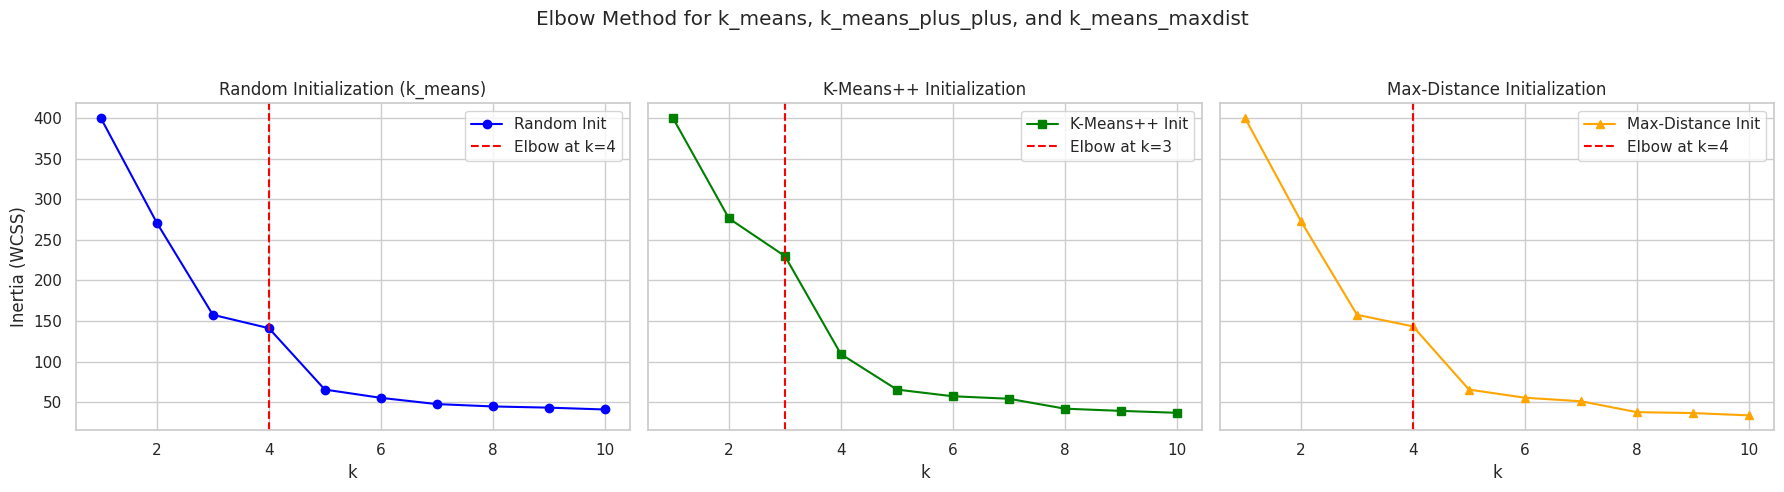

In [276]:
 # for Annual Income vs Spending Score
elbow_method(X1_scaled)

### Custom K-Means (random initialization) with the optimal k = 4

In [277]:
k = 4
centroids_kmeans, labels_kmeans = k_means(X1_scaled, k)

K-means converged after 7 iterations.


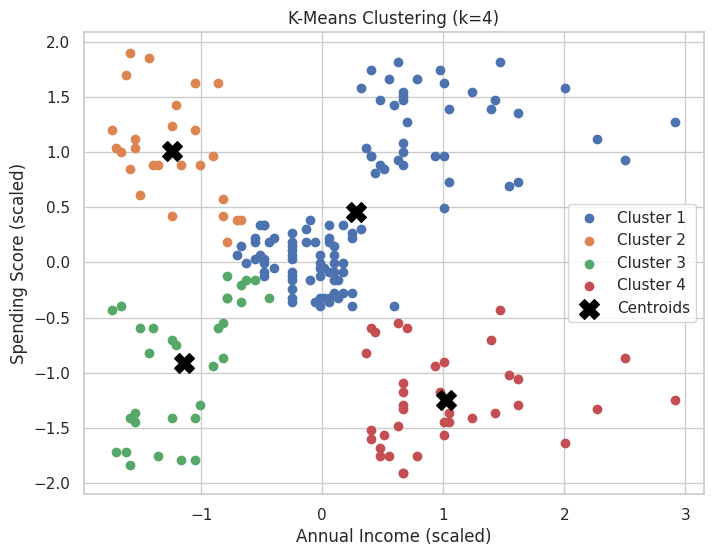

In [278]:
# Plot the clustered points
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_points = X1_scaled[labels_kmeans == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot the centroids
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], s=200, c='black', marker='X', label='Centroids')


plt.title('K-Means Clustering (k=4)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.grid(True)
plt.show()

### K-Means++ with the optimal k = 3

In [279]:
k = 3
centroids_kpp, labels_kpp = k_means_plus_plus(X1_scaled, k)

K-means++ converged after 5 iterations.


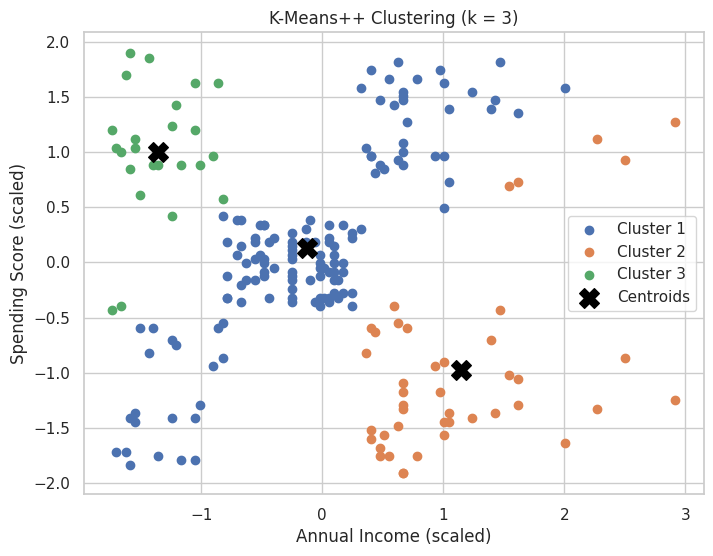

In [280]:
# Plot the clustered data points
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_points = X1_scaled[labels_kpp == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot the centroids
plt.scatter(centroids_kpp[:, 0], centroids_kpp[:, 1],
            s=200, c='black', marker='X', label='Centroids')

plt.title('K-Means++ Clustering (k = 3)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.grid(True)
plt.show()

### Custom K-Means (Max distance initialization) with the optimal k = 4

In [281]:
k = 4
centroids_maxdist, labels_maxdist = k_means_maxdist(X1_scaled, k)

K-Means (Max-Distance) converged after 5 iterations.


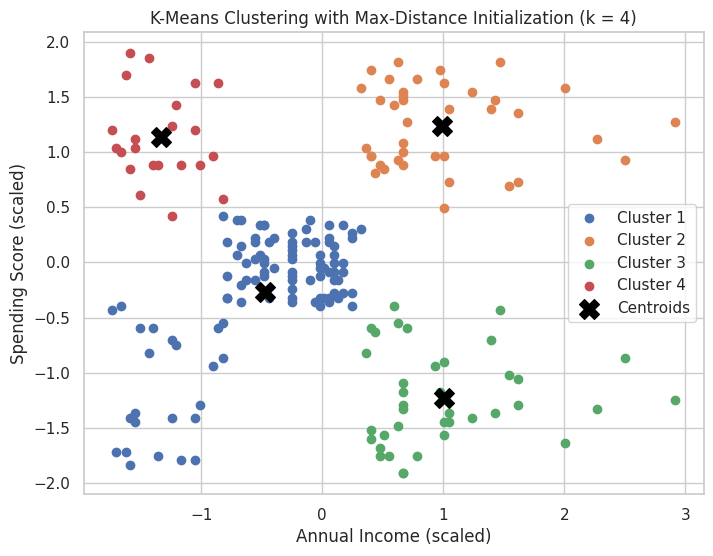

In [282]:
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_points = X1_scaled[labels_maxdist == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot the centroids
plt.scatter(centroids_maxdist[:, 0], centroids_maxdist[:, 1],
            s=200, c='black', marker='X', label='Centroids')

plt.title('K-Means Clustering with Max-Distance Initialization (k = 4)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.grid(True)
plt.show()

## Answers to the Conceptual Quiz

 #### What is the objective function optimized in K-means?
The **within-cluster sum of squares (WCSS)**, also called **inertia**, is minimized. It measures the total squared distance between each point and the centroid of its assigned cluster.



**Mathematical Formulation:**

Let:  
- $ X = \{x_1, x_2, \dots, x_n\} $ be the dataset,  
- $ C = \{C_1, C_2, \dots, C_k\} $ be the k clusters,  
- $ \mu_j $ be the centroid of cluster $ C_j $,  

Then the WCSS is:

$$
\text{WCSS} = \sum_{j=1}^{k} \sum_{x_i \in C_j} \| x_i - \mu_j \|^2
$$

It computes the sum of squared Euclidean distances between each point and the centroid of its assigned cluster.

---

#### Why can initialization affect the result?
K-means converges to a **local minimum**, not a global one. Poor initialization can lead to bad clusters, while good initialization improves clustering quality and convergence speed.

---

#### How can we choose K without labels?
Use unsupervised methods like:
- **Elbow Method**: Find the k where inertia drops sharply.
- **Silhouette Score**: Measures how well points fit in their clusters.

---

#### When does K-means fail?
K-means may fail when:
- Clusters are **not spherical** or have different **densities or sizes**.
- Data contains **outliers** or **non-linear boundaries**.
- **Initialization** is poor, leading to bad convergence.
- The true clusters **overlap significantly**.

---
